In [1]:
from IPython.display import HTML

def hide_toggle(for_next=False):
    target_cell = """$('div.cell.code_cell.rendered.selected')"""  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)
    html = """
        <script>
            function f_name() {{
                {cell_selector}.find('div.input').toggle();
            }}
            {js_hide_current}
            
        </script>
        <form action="javascript:f_name()"><input type="submit" id="toggleButton" value="Show/Hide Code"></form>
    """.format(
        cell_selector=target_cell,
        js_hide_current=js_hide_current
    )

    return HTML(html)

hide_toggle()

[Return to NeoPZ-Overview](NeoPZ-Overview.ipynb)

## 4. The geometric mesh

A geometric mesh TPZGeoMesh is class that stores a vector of geometric nodes (*TPZGeoNode*) and geometric elements (TPZGeoEl) (see [Geometry Documentation](Geometry.ipynb)).

Besides implementing access functions for nodes and elements, the *TPZGeoMesh* class implements a method to compute the neighbouring information for all elements


* *BuildConnectivity*: Computes the neighbouring information of the geometric elements.

The mesh also includes a method that finds an element that contains a given coordinate.

* *FindElement*: Returns the element that contains the given point x and it respective point in parametric domain qsi.
(It should be noted that FindElement is not 100%. It can break for quarterpoint geometric maps).

### 4.1. The geometric node

The geometric node stores the 3D coordinates of a node and a unique ID associated with the node. The ID is essential because it will determine the orientation associated with shape functions.

The class *TPZCheckGeom* includes a method to verify if the ID’s of the geometric nodes are unique.

### 4.2 The geometric element

A geometric element represents an area in the geometric mesh. It has several attributes within the NeoPZ library:

* Compute the map between the master element and deformed configuration
* Associate a material id with the area
* Keep track of neighbour information
* Keep track of son elements and father element
* Keep a pointer to a computational element
* Keep a counter of the number of interface elements pointing to this geometry (to be deleted)

(More details in [Geometry Documentation](Geometry.ipynb))

The geometric element class is abstract. Many functionalities are implemented the derived class *TPZGeoElRefless*
The methods of the geometric element can be classified as:

* Access and initialization methods for the geometric nodes:


    1. void GetNodeIndices( TPZVec<int64_t> &nodeindices );
    
    2. void GetNodeIndices( std::set<int64_t> &nodeindices );
    
    3. virtual int NNodes() const = 0;
        Returns the number of nodes of the element
        
    4. virtual int NCornerNodes() const = 0;  
        Returns the number of corner nodes of the element  
    
    5. TPZGeoNode* NodePtr(int i) const;
        Returns a pointer to the ith node of the element 
    
    6. TPZGeoNode& Node(int i) const;
    
    7. virtual int64_t NodeIndex(int i) const = 0;
        Returns the ith node of the element  

* Provide information of the topology associated with the element:


    1. virtual int NSides() const = 0;
        Returns the number of sides;
    
    2. virtual int NSideNodes(int side) const = 0;
        Returns the number of nodes for a particular side
    
    3. virtual TPZGeoNode * SideNodePtr(int side,int nodenum) const;
        Returns the pointer to the nodenum node of side
    
    4. virtual void MidSideNodeIndex(int side,int64_t &index) const = 0;
        Returns the midside node index along a side of the element
    
    5. virtual void MidSideNodeIndices(int side,TPZVec<int64_t> &indices) const;
        Returns the midside node indices along a side of the element. THIS METHOD SHOULD SUBSTITUTE MidSideNodeIndex in the future as it is ready for Refinement patterns, whereas the former is not
    
    6. virtual int64_t SideNodeIndex(int side,int nodenum) const = 0;
        Returns the index of the nodenum node of side.
        
    7. virtual int SideNodeLocIndex(int side, int nodenum) const = 0;
        Returns the local index of a node on a side
    
    8. int WhichSide(TPZVec<int64_t> &SideNodeIds);
        Returns the side number which is connected to the SideNodes returns -1 if no side is found
    
    9. virtual void SetNodeIndex(int i,int64_t nodeindex) = 0;
        Initializes the node i of the element

    10. virtual int SideDimension(int side) const = 0;
        Return the dimension of side

    11. virtual int Dimension() const =0;
        Returns the dimension of the element

    12. virtual void AllHigherDimensionSides(int side,int targetdimension,TPZStack<TPZGeoElSide> &elsides) = 0;

    13. virtual void LowerDimensionSides(int side,TPZStack<int> &smallsides) const = 0;

    14. virtual TPZTransform<REAL> SideToSideTransform(int sidefrom,int sideto) = 0;
        Compute the transformation between the master element space of one side of an element to the master element space of a higher dimension side

    15. virtual void ProjectPoint(int sidefrom, TPZVec<REAL> &ptin, int sideto, TPZVec<REAL> &ptout)
        Project the point from one side to another. The dimension of the
points needs to be configured properly

    16. TPZTransform<REAL> Projection(int side)
        Compute the projection of the point within the interior of the
element to the side of the element

    17. int WhichSide(TPZVec<REAL> &pt)
        Returns the side number which is connected to the point pt

    18. virtual void CenterPoint(int side, TPZVec<REAL> &masscent) const = 0;
        It returns the coordinates from the center of the side of the element in the element coordinate space

    19. virtual REAL RefElVolume() = 0;
        Volume of the master element

    19. virtual bool IsInParametricDomain(const TPZVec<REAL> &pt, REAL tol = 1.e-2) = 0;
        Verifies if the parametric point pt is in the element parametric
domain

    20. virtual int ProjectInParametricDomain(TPZVec<REAL> &qsi, TPZVec<REAL> &qsiInDomain) = 0;
        Ortogonal projection from given qsi to a qsiInDomain (all in the element parametric domain). Returns the side where the point was projected. Note: If ortogonal projection to any sides of element results in a qsi outside domain, this method will returns the nearest node side.Observe that if the point is already in the parametric domain, the method will return \f$ NSides() - 1 \f$

    21. virtual int ProjectBissectionInParametricDomain(TPZVec<REAL> &qsi, TPZVec<REAL> &qsiInDomain) = 0;
        Projection from given qsi to a qsiInDomain (in the element bound- ary) using bissection method from given qsi to element center. Returns the side where the point was projected. Note: Observe that if the point is already in the parametric domain, the method will return \f$ NSides() - 1 \f$ */

### 4.3. Creating a refinement pattern

The following tutorial explains how to create refinement patterns using NeoPZ.

1. Create a TPZGeoMesh with the refinement pattern (one element father and its children).

    NOTE: Don't forget to set the Father, for example:
            gmesh->Element(1)->SetFather(gmesh->Element(0));
            gmesh->Element(2)->SetFather(gmesh->Element(0));

2. Create a TPZGeoMesh without the refinement

3. Set the refinement with the procedure:

            TPZRefPattern *ref = new TPZRefPattern(*gmeshWITHpattern);
            ref->SetName("Karol");
            TPZAutoPointer<TPZRefPattern> autoref(ref);
            gRefDBase.InsertRefPattern(autoref);
            autoref->InsertPermuted();
            auto karol = gRefDBase.FindRefPattern("Karol");
            
            TPZVec<TPZGeoEl *> gelvec;
            gmeshWITHOUTpattern->Element(0)->SetRefPattern(karol);
            gmeshWITHOUTpattern->Element(0)->Divide(gelvec);
    
    NOTE: Since the refinement pattern is compatible with the subelement, you can divide how many times you want.

#### 4.3.1 Example with quadrilateral elements

In [2]:
import pyvista as pv

def plotref_qd1():
    mesh1 = pv.UnstructuredGrid('RefPatterns/QuadExamples/QuadRef1.vtk')
    edges1 = mesh1.extract_edges()
    p1 = pv.Plotter()
    p1.add_mesh(mesh1)
    p1.add_mesh(edges1, color="red", line_width=5)
    return p1.show()

def plotref_qd2():
    mesh2 = pv.UnstructuredGrid('RefPatterns/QuadExamples/QuadRef2.vtk')
    edges2 = mesh2.extract_edges()
    p2 = pv.Plotter()
    p2.add_mesh(mesh2)
    p2.add_mesh(edges2, color="red", line_width=5)
    return p2.show()
    
def plotref_tr1():
    mesh1 = pv.UnstructuredGrid('RefPatterns/TriangleExamples/TriangleRef1.vtk')
    edges1 = mesh1.extract_edges()
    p1 = pv.Plotter()
    p1.add_mesh(mesh1)
    p1.add_mesh(edges1, color="red", line_width=5)
    return p1.show()

def plotref_tr2():
    mesh2 = pv.UnstructuredGrid('RefPatterns/TriangleExamples/TriangleRef2.vtk')
    edges2 = mesh2.extract_edges()
    p2 = pv.Plotter()
    p2.add_mesh(mesh2)
    p2.add_mesh(edges2, color="red", line_width=5)
    return p2.show()

hide_toggle()

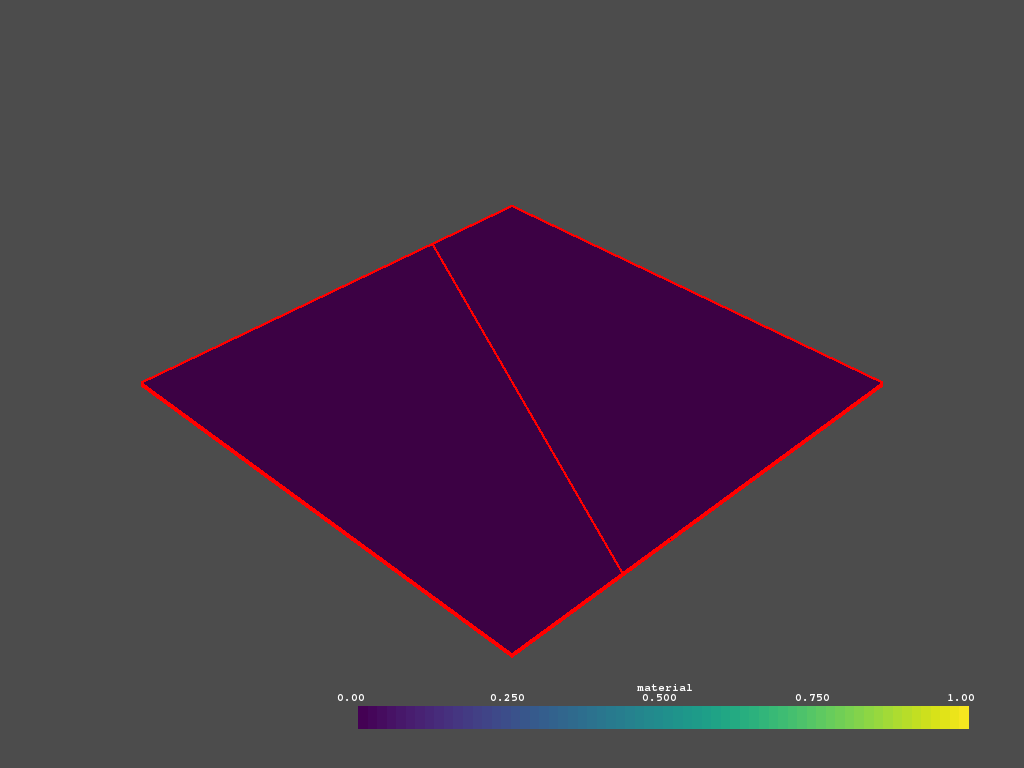

In [3]:
# Element refinement pattern
plotref_qd1()

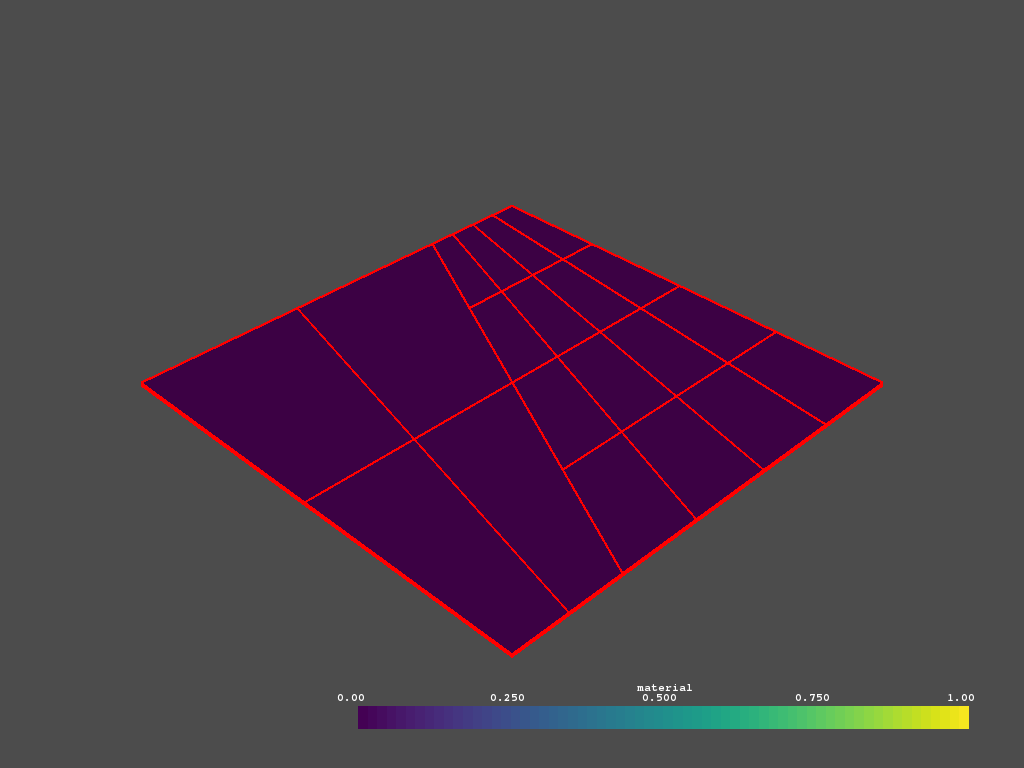

In [4]:
# Three level refinement
plotref_qd2()

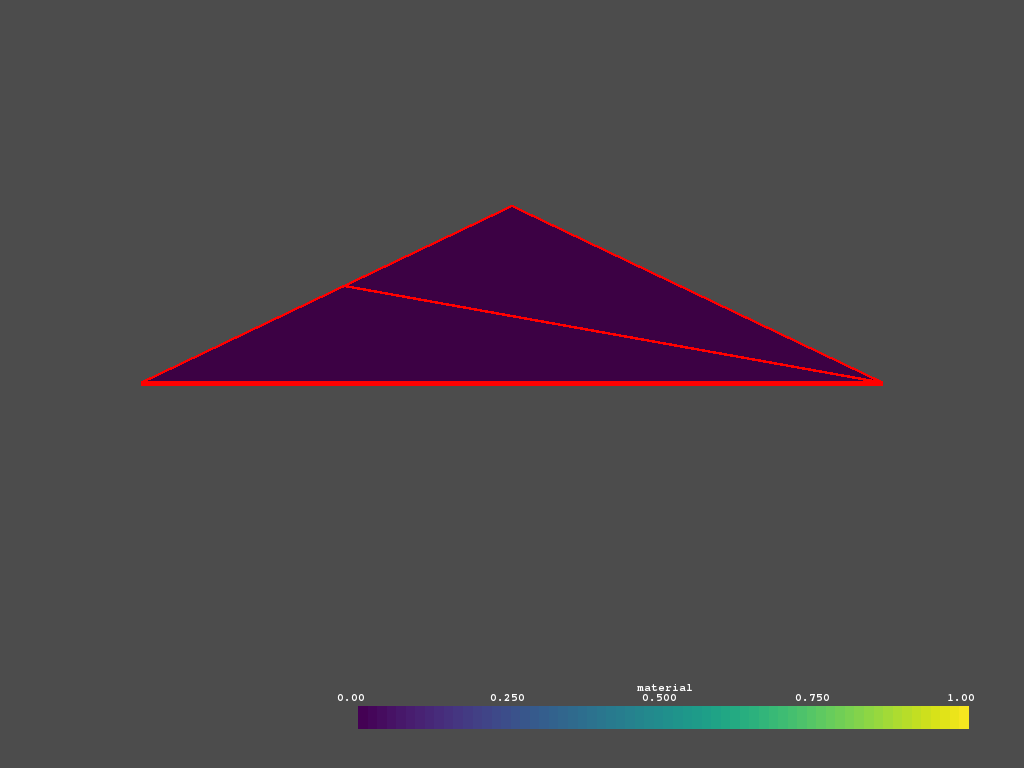

In [5]:
# Element refinement pattern
plotref_tr1()

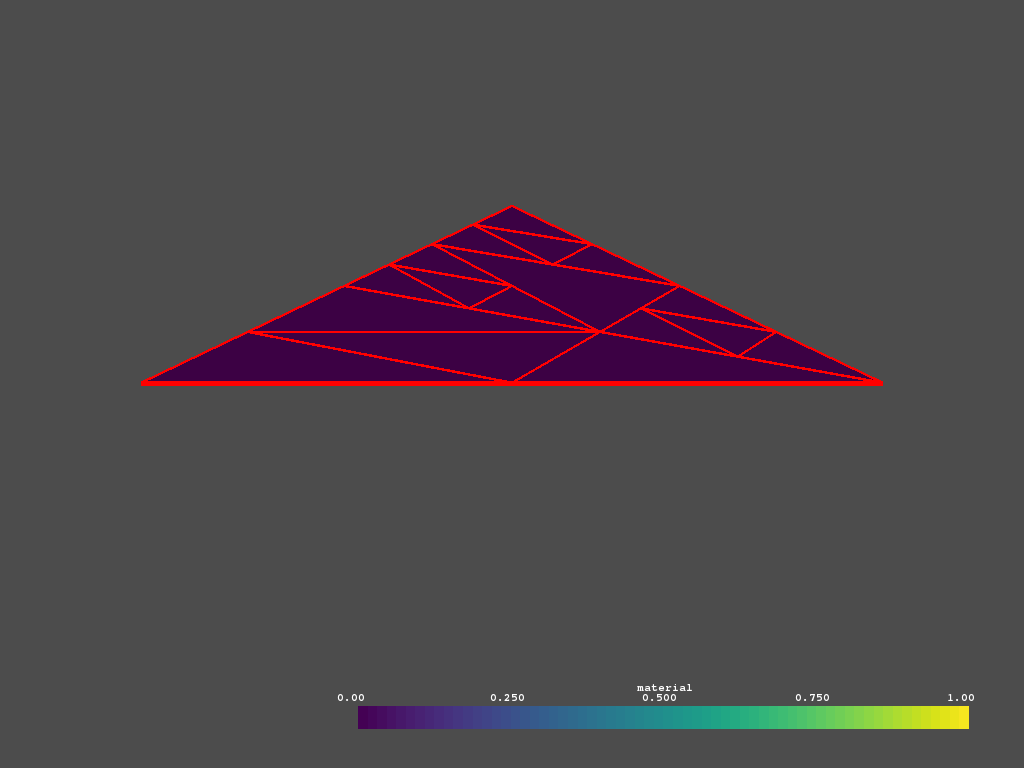

In [6]:
plotref_tr2()